---

## **Thư viện**

In [1]:
import random
import math
import heapq
import csv
import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.backends.backend_agg import FigureCanvasAgg
from PIL import Image, ImageTk

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances
from kneed import KneeLocator

---
## **Class Position & Class Cell**

In [2]:
class Position:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def __hash__(self):
        return hash((self.x, self.y))

class Cell:
    def __init__(self, position, parent, status, g, h):
        self.position = position
        self.parent = parent
        self.status = status
        self.g = g  # Chi phí từ điểm bắt đầu đến vị trí hiện tại
        self.h = h  # Chi phí ước lượng đến điểm đích (heuristic)

    def f(self):
        return self.g + self.h
    
    # Thêm phương thức __lt__ để hỗ trợ so sánh giữa các Cell
    def __lt__(self, other):
        return self.f() < other.f()  # So sánh theo tổng chi phí f

---

## **Robot Cleaner using A-Star Algorithm**

In [3]:
class RobotVacuumCleaner:
    def __init__(self, filepath=None):
        self.matrix_size = (0, 0)
        self.dirty_count = 0
        self.grid = []
        self.start_position = None
        self.dirty_positions = []
        self.robot_position = None
        self.path_taken = []
        self.total_cost = 0
        self.dirty_costs = {}
        self.dirty_mantain = None
        self.thu_tu = {}
        
        self.load_grid_from_csv(filepath)
    

    def load_grid_from_csv(self, filepath):
        with open(filepath, newline='') as csvfile:
            reader = csv.reader(csvfile)
            self.grid = [row for row in reader]
            self.grid = self.grid[::-1]
            self.matrix_size = (len(self.grid), len(self.grid[0]))
            
            count = 0

            for i, row in enumerate(self.grid):
                for j, cell in enumerate(row):
                    if cell == 'start':
                        self.start_position = Position(i, j)
                        self.robot_position = Position(i, j)
                    elif cell == 'dirty':
                        count += 1
                        self.dirty_positions.append(Position(i, j))
                        self.dirty_costs[(i, j)] = 1

            self.dirty_count = count
            self.dirty_maintain = count
    
    def cluster_dirty_cells(self, epsilon=1.5, min_samples=1, grid_new = None):
        dirty_positions_coords = []
        dirty = 0
        for i, row in enumerate(grid_new):
            for j, cell in enumerate(row):
                if cell == 'dirty':
                    dirty_positions_coords.append((i, j))
                    dirty += 1

        if not dirty_positions_coords:
            return None

        if dirty == 1:
            mean_distance = 1.5

        else:
            # Tính ma trận khoảng cách
            distances = pairwise_distances(dirty_positions_coords, metric='euclidean')
            
            # Lấy các khoảng cách gần nhất (trừ khoảng cách chính nó là 0)
            sorted_distances = np.sort(distances, axis=1)[:, 1]  # Lấy khoảng cách nhỏ nhất khác 0
            
            # Sắp xếp các khoảng cách tăng dần
            sorted_distances = np.sort(sorted_distances)

            # Xác định điểm gấp khúc (elbow point) tự động
            knee_locator = KneeLocator(range(len(sorted_distances)), sorted_distances, curve="convex", direction="increasing")
            
            if knee_locator.knee is not None:
                mean_distance = sorted_distances[knee_locator.knee]
            else:
                # Fallback
                mean_distance = np.median(sorted_distances)
        
        # Áp dụng DBSCAN với khoảng cách Chebyshev
        clustering = DBSCAN(eps=mean_distance, min_samples=min_samples, metric='euclidean').fit(dirty_positions_coords)
        
        # Phân cụm các ô bẩn
        clusters = {}
        for label, pos in zip(clustering.labels_, dirty_positions_coords):
            if label not in clusters:
                clusters[label] = []
            clusters[label].append(Position(pos[0], pos[1]))

        self.dirty_clusters = clusters
        return clusters


    def is_within_bounds(self, position):
        return 0 <= position.x < self.matrix_size[0] and 0 <= position.y < self.matrix_size[1]


    def get_neighbors(self, cell):
        moves = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
        neighbors = []
        for dx, dy in moves:
            neighbor_pos = Position(cell.position.x + dx, cell.position.y + dy)
            if self.is_within_bounds(neighbor_pos):
                neighbors.append(neighbor_pos)
        return neighbors

    def heuristic(self, pos1, pos2):
        # return max(abs(pos1.x - pos2.x), abs(pos1.y - pos2.y))    #Chebyshev
        # return abs(pos1.x - pos2.x) + abs(pos1.y - pos2.y)        #Mahattan
        # Euclid
        return math.sqrt((pos1.x - pos2.x) ** 2 + (pos1.y - pos2.y) ** 2)
        
    def display_grid(self):

        status_map = {
            'start': '#D4343F',  # Vị trí bắt đầu
            'free': '#FFFFFF',   # Ô trống
            'dirty': '#06D7A0',  # Ô bẩn
            'clean': '#ADE1FB',  # Ô đã sạch
            'R': '#FFD167'       # Đường đi
        }

        rows, cols = len(self.grid), len(self.grid[0])
        fig, ax = plt.subplots(figsize=(cols / 3, rows / 3))

        # Vẽ từng ô
        for i in range(rows):
            for j in range(cols):
                state = self.grid[i][j]
                color = status_map.get(state, '#FFFFFF')
                rect = Rectangle((j, i), 1, 1, facecolor=color, edgecolor='black', linewidth=0.5)
                ax.add_patch(rect)

        # Vẽ đường đi
        if self.path_taken:
            x_coords = [pos.y + 0.5 for pos in self.path_taken]
            y_coords = [pos.x + 0.5 for pos in self.path_taken]
            ax.plot(x_coords, y_coords, linestyle='--', color='blue', alpha=0.4)

            # Đánh số thứ tự
            # clean_counter = 1
            # for pos in self.path_taken:
            #     if self.grid[pos.x][pos.y] == 'clean':
            #         ax.text(pos.y + 0.5, pos.x + 0.5, f'{clean_counter}', 
            #                 ha='center', va='center', color='black', fontsize=8)
            #         clean_counter += 1
        for cell_dirty, value in self.thu_tu.items():
            ax.text(cell_dirty[1] + 0.5, cell_dirty[0] + 0.5, f'{value}', 
                    ha='center', va='center', color='black', fontsize=8)
                    
        # Trục tọa độ
        ax.invert_yaxis()  # Đảo ngược trục y
        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        ax.set_aspect('equal')
        ax.set_xticks(np.arange(0.5, cols, 1))
        ax.set_xticklabels(np.arange(1, cols + 1, 1))  # Trục OX
        ax.set_yticks(np.arange(0.5, rows, 1))
        ax.set_yticklabels(np.arange(1, rows + 1, 1))  # Trục OY
        ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

        return fig

    def a_star_search(self, start_position, goal_position):
        open_set = []
        came_from = {}
        start_cell = Cell(start_position, None, 'start', 0, 0)
        heapq.heappush(open_set, start_cell)
        
        path = []
        while open_set:
            current_cell = heapq.heappop(open_set)
            if current_cell.position == goal_position:
                path = []
                current = current_cell
                while current in came_from:
                    path.append((current.position.x, current.position.y))
                    current = came_from[current]
                path.append((start_position.x, start_position.y))
                return path[::-1]
            
            for neighbor_pos in self.get_neighbors(current_cell):
                neighbor = Cell(neighbor_pos, current_cell, 'free' or 'clean', float('inf'), self.heuristic(neighbor_pos, goal_position))
                tentative_g_score = current_cell.g + 1
                if tentative_g_score < neighbor.g:
                    came_from[neighbor] = current_cell
                    neighbor.g = tentative_g_score
                    heapq.heappush(open_set, neighbor)

        return None


    def update_dirty_costs(self):
        for pos in self.dirty_positions:
            if self.grid[pos.x][pos.y] == 'dirty':
                self.dirty_costs[(pos.x, pos.y)] += 1


    def clean_clusters(self):
        grid_new = [row[:] for row in self.grid]
        count_dirty = 0

        # Gom cụm các ô bẩn
        clusters = self.cluster_dirty_cells(grid_new = grid_new)

        if not clusters:  # Nếu không có cụm nào (cụm rỗng), kết thúc sớm
            print("Không có ô bẩn nào để làm sạch.")
            return 0
        
        alpha = 1.5  # Trọng số ưu tiên cho kích thước cụm
        beta = 1.0   # Trọng số ưu tiên cho khoảng cách

        # Xử lý lần lượt từng cụm
        while clusters:
            # Sắp xếp các cụm theo số lượng ô bẩn (cụm lớn nhất trước)
            clusters_with_distance = []
            for key_cluster, cluster in clusters.items():
                if cluster:
                    # Tính khoảng cách từ robot đến ô gần nhất trong cụm
                    min_distance = min(self.heuristic(self.robot_position, pos) for pos in cluster)
                    score = alpha * len(cluster) - beta * min_distance
                    clusters_with_distance.append((cluster, score, key_cluster))

            clusters_with_distance.sort(key=lambda x: x[1], reverse=True)

            cluster_to_clean = clusters_with_distance[0][0]
            key_cluster = clusters_with_distance[0][2]

            # Tìm ô bẩn gần robot nhất trong cụm
            closest_dirty = min(cluster_to_clean, key=lambda pos: self.heuristic(self.robot_position, pos))

            # Di chuyển đến ô gần nhất trong cụm và làm sạch
            path_to_cluster = self.a_star_search(self.robot_position, closest_dirty)
            for step in path_to_cluster[1:]:  # Bỏ qua bước đầu tiên vì đó là vị trí hiện tại của robot
                self.robot_position = Position(step[0], step[1])
                self.path_taken.append(self.robot_position)
                self.total_cost += 1
                self.update_dirty_costs()

            # Làm sạch từng ô trong cụm đã chọn
            while cluster_to_clean:
                closest_dirty = min(cluster_to_clean, key=lambda pos: self.heuristic(self.robot_position, pos))
                path = self.a_star_search(self.robot_position, closest_dirty)

                # Di chuyển qua các ô trên đường đi
                for step in path[1:]:
                    self.robot_position = Position(step[0], step[1])
                    self.path_taken.append(self.robot_position)
                    self.total_cost += 1
                    self.update_dirty_costs()

                # Làm sạch ô hiện tại
                count_dirty += 1
                self.grid[closest_dirty.x][closest_dirty.y] = 'clean'
                cluster_to_clean.remove(closest_dirty)
                self.total_cost += self.dirty_costs.get((closest_dirty.x, closest_dirty.y), 0)
                del self.dirty_costs[(closest_dirty.x, closest_dirty.y)]
                grid_new[closest_dirty.x][closest_dirty.y] = 'clean'
                self.thu_tu[(closest_dirty.x, closest_dirty.y)] = count_dirty

            # Sau khi làm sạch một cụm, phân cụm lại các ô bẩn còn lại
            del clusters[key_cluster]
        
        return self.total_cost
    
    def display_results(self):
        """
        Hiển thị lộ trình của robot và tổng chi phí
        """
        print("Lộ trình di chuyển của robot:")
        for step in self.path_taken:
            print((step.x + 1, step.y + 1), end=" ➝ ")
        print("Hoàn thành")
        print(f"Số bước: {len(self.path_taken)}")
        print(f"Tổng chi phí: {self.total_cost}")


---

## **Giao diện chương trình**

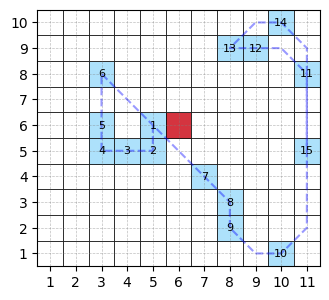

In [4]:
import tkinter as tk
from tkinter import messagebox
import csv

root = tk.Tk()
width = 1000
height = 700
x = (root.winfo_screenwidth() // 2) - (width // 2)
y = (root.winfo_screenheight() // 2) - (height // 2)
root.geometry(f"{width}x{height}+{x}+{y}")
root.title("Robot Cleaner using A-Star Algorithm")

# Khởi tạo grid
root.columnconfigure(0, weight=1)
root.columnconfigure(1, weight=0)
root.rowconfigure(0, weight=1)
root.rowconfigure(1, weight=0) 


# Các hàm xử lý

# Nút Confirm
def confirm():
    try:
        m = int(entry_m.get())
        n = int(entry_n.get())
        if m <= 0 or n <= 0:
            raise ValueError("Giá trị m và n phải lớn hơn 0.")
    except ValueError as e:
        messagebox.showerror("Lỗi", f"Lỗi nhập liệu: {e}")
        return
    create_matrix_window(m, n)

# Ma trận đầu vào
def create_matrix_window(m, n):
    for widget in main_frame.winfo_children():
        widget.destroy()

    matrix_frame = tk.Frame(main_frame, bg="white")
    matrix_frame.grid(row=0, column=0, padx=10, pady=10)
    main_frame.grid_rowconfigure(0, weight=1)
    main_frame.grid_columnconfigure(0, weight=1)

    # Tạo ma trận để lưu các trạng thái
    matrix = [['F' for _ in range(n)] for _ in range(m)]
    buttons = []

    # Hàm xử lý khi click vào ô
    def on_cell_click(i, j):
        nonlocal matrix
        if matrix[i][j] == 'F':  # Ô sạch -> Chọn vị trí bắt đầu
            matrix[i][j] = 'R'
            buttons[i][j].config(text='R', font=('Arial', 9, 'bold'), bg='green', fg='white')
        elif matrix[i][j] == 'R':  # Vị trí bắt đầu -> Ô dơ
            matrix[i][j] = 'D'
            buttons[i][j].config(text='D', font=('Arial', 9, 'bold'), bg='red', fg='white')
        else:  # Ô dơ -> Trở lại ô sạch
            matrix[i][j] = 'F'
            buttons[i][j].config(text='', font=('Arial', 9, 'bold'), bg='white', fg='black')

    # Trục x,y
    for i in range(m):
        tk.Label(matrix_frame, text=str(m - i), font=('Arial', 10, 'bold'), bg="white").grid(row=i + 1, column=0, padx=5, pady=2)
    for j in range(n):
        tk.Label(matrix_frame, text=str(j + 1), font=('Arial', 10, 'bold'), bg="white").grid(row=m + 1, column=j + 1, padx=5, pady=2)

    #Random vị trí ô dơ entry_dirty_count
    try:
        if dirty_pos_var.get() == "specify":
            dirty_count = int(entry_dirty_count.get()) + 1
            if dirty_count <= 0 or dirty_count > m * n:
                raise ValueError("Số ô dơ phải lớn hơn 0 và nhỏ hơn tổng số ô trong ma trận.")
            
            all_positions = [(i, j) for i in range(m) for j in range(n)]
            dirty_positions = random.sample(all_positions, dirty_count)
     
            start_position = random.choice(dirty_positions)
            for i, j in dirty_positions:
                matrix[i][j] = 'D'
            matrix[start_position[0]][start_position[1]] = 'R'
    except ValueError as e:
        messagebox.showerror("Lỗi", f"Lỗi nhập liệu: {e}")
        return
    
    # Tạo các nút bấm để thay đổi trạng thái
    for i in range(m):
        row_buttons = []
        for j in range(n):
            bg_color = 'red' if matrix[i][j] == 'D' else ('green' if matrix[i][j] == 'R' else 'white')
            text = matrix[i][j] if matrix[i][j] != 'F' else ''
            btn = tk.Button(matrix_frame, text=text, width=5, height=2, bg=bg_color,
                            command=lambda i=i, j=j: on_cell_click(i, j))
            btn.grid(row=i + 1, column=j + 1, padx=2, pady=2)
            row_buttons.append(btn)
        buttons.append(row_buttons)

    # In ma trận kết quả
    def display_matrix(filepath="matrix.csv"):
        for widget in main_frame.winfo_children():
            widget.destroy()

        # Khởi tạo robot từ file CSV
        robot = RobotVacuumCleaner(filepath)
        total_cost = robot.clean_clusters()

        # Khung hiển thị kết quả
        result_frame = tk.Frame(main_frame, bg="white")
        result_frame.pack(fill="both", expand=True, padx=5, pady=5)
        grid_label = tk.Label(result_frame, text="Robot Path Visualization", font=("Arial", 10, "bold"), bg="white")
        grid_label.pack(pady=5)

        # Hiển thị ma trận kết quả
        def capture_grid_as_image():
            fig = robot.display_grid() 
            buffer = io.BytesIO()
            canvas = FigureCanvasAgg(fig)
            canvas.print_png(buffer) 
            buffer.seek(0)
            img = Image.open(buffer)
            return img
        grid_image = capture_grid_as_image()
        grid_photo = ImageTk.PhotoImage(grid_image)
        image_label = tk.Label(result_frame, image=grid_photo, bg="white")
        image_label.image = grid_photo 
        image_label.pack(padx=5, pady=5)

        # Hiển thị kết quả Cost
        result_label = tk.Label(result_frame, text="Kết quả dọn dẹp", font=("Arial", 10, "bold"), bg="white")
        result_label.pack(pady=5)
        result_text = tk.Text(result_frame, width=130, height=5, font=("Arial", 10), bg="lightgray", wrap="none")
        result_text.pack(padx=5, pady=5)
        def capture_result_output():
            import io
            import sys
            buffer = io.StringIO()
            sys.stdout = buffer
            robot.display_results() 
            sys.stdout = sys.__stdout__ 
            return buffer.getvalue()
        result_content = capture_result_output()
        result_text.insert("1.0", result_content)
        result_text.config(state="disabled")

    #Nút Run
    def run():
            # Chuyển đổi trạng thái từ 'R', 'D', 'F' sang 'start', 'dirty', 'free'
            for i in range(m):
                for j in range(n):
                    if matrix[i][j] == 'R':
                        matrix[i][j] = 'start'
                    elif matrix[i][j] == 'D':
                        matrix[i][j] = 'dirty'
                    else:
                        matrix[i][j] = 'free'

            # Lưu ma trận vào file CSV
            with open("matrix.csv", "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerows(matrix)
            display_matrix(filepath='matrix.csv')
    run_button = tk.Button(input_fm, text="Run", command=run, bg="#046200", fg="white", font=('Arial Bold', 11), width=8)
    run_button.grid(row=0, column=5, padx=15)

    # Nút Reset
    def reset():
        entry_m.delete(0, tk.END)
        entry_n.delete(0, tk.END)
        entry_dirty_count.delete(0,tk.END)
        for widget in main_frame.winfo_children():
            widget.destroy()
    reset_button = tk.Button(input_fm, text="Reset", command=reset, bg="#ffb703", fg="black", font=('Arial Bold', 11), width=8)
    reset_button.grid(row=1, column=5, padx=15)

# Toggle nút ô dơ
def toggle_entries(*args):
    if dirty_pos_var.get() == "random":
        entry_dirty_count.config(state="disabled")
    else:
        entry_dirty_count.config(state="normal")

# Main Frame
main_frame = tk.Frame(root)
main_frame.grid(column=0, row=0, sticky='nsew', padx=10, pady=10, columnspan=2)
main_fm = tk.Label(main_frame, bg="white", width=500, height=200)
main_fm.pack(fill='both', expand=True, ipadx=10, ipady=10)

# Input Frame
input_fm = tk.Frame(root, bg='lightgray')
input_fm.grid(column=0, row=1, sticky='ew', padx=10, pady=10, columnspan=2)

#Input giá trị m, n
label_m = tk.Label(input_fm, text="Số hàng:",
                   font=('Arial Bold', 11), bg='lightgray').grid(row=0, column=0, padx=10, pady=10, sticky='w')
entry_m = tk.Entry(input_fm, width=30)
entry_m.grid(row=0, column=1, padx=10, pady=10)

label_n = tk.Label(input_fm, text="Số cột:",
                   font=('Arial Bold', 11), bg='lightgray').grid(row=0, column=2, padx=10, pady=10, sticky='w')
entry_n = tk.Entry(input_fm, width=30)
entry_n.grid(row=0, column=3, padx=10, pady=10)

# Vị trí bắt đầu của robot
dirty_pos_var = tk.StringVar(value="random")
dirty_pos_var.trace("w", toggle_entries)

tk.Label(input_fm, text="Số ô dơ:", font=('Arial Bold', 11), bg='lightgray').grid(row=1, column=0, padx=10, pady=10, sticky='w')

tk.Radiobutton(input_fm, text="Chỉ định", font=('Arial', 11), bg='lightgray',
variable=dirty_pos_var, value="random").grid(row=1, column=1, pady=5, sticky='we')
tk.Radiobutton(input_fm, text="Chỉ định số lượng, ngẫu nhiên vị trí", font=('Arial', 11), bg='lightgray',
variable=dirty_pos_var, value="specify").grid(row=1, column=2, pady=5, sticky='we')

entry_dirty_count = tk.Entry(input_fm, width=30, state="disabled")
entry_dirty_count.grid(row=1, column=3, padx=10, pady=10, sticky='e')


# Nút xác nhận
confirm_button = tk.Button(input_fm, text="Xác nhận", font=('Arial Bold', 11), bg='#22487a', fg='white',
                           command=confirm)
confirm_button.grid(row=0,column = 4, padx=15)

#Nút Quit
quit_button=tk.Button(input_fm, text="Quit", font=('Arial Bold', 11), bg="#980404", fg="white", width=8,
          command=root.destroy).grid(row=1, column=4, padx=15)


root.mainloop()